# Predict Property Value for Zillow

### Description:
 To find what are the biggest drivers of property value in single family homes back around 2017.

From 52238 entries and 13 columns (features), I will explore the Zillow data from 2017 to come up 
 with my best recommendation of property value drivers.

### Goals:

1. To find what features of a property that drive property value the most.
2. To make a regression model that can accurately predict property values using engineered features.

My hypothosis is that fips or county is a driver in property value, along with calculated finished sq ft.
I will run stats tests and look at vizualiztions to see which features have the greatest correlation.

### My 4 questions:

Is calculatedfinishedsquarefeet a driver of property value?

Do the year built and calcultedfinishedsquarefeet have any correlation?

Is fips a driver of property value?

Is year built a driver of property value?

After my testing and visualization I will attempt to make a regression model that runs off of engineered features that can best predicted property value.

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from env import host, username, password
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import wrangle

# AQUIRE

In [2]:
# Aquire data
df = wrangle.get_zillow_data()

# PREP 
Zillow Data showing the % of missing/changed values
nulls and nans were made to be an average number of said column so all data below $5 million taxvaluedollarcnt is used

In [3]:
# Prep Zillow Data
df = wrangle.prep_zillow(df)

Percentage of rows with missing values in all columns: 0.08%
Percentage of data not used: 0.00%


Showing zillow data sample so you can see the columns (features) being observed for this analysis

In [4]:
# show a sample of the data 
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt
0,3.0,3.0,2538.0,6037.0,39238.0,0.0,1966.0,878288.0
1,2.5,4.0,2761.0,6059.0,5800.0,0.0,1998.0,556255.0
2,2.5,3.0,1371.0,6111.0,4321.0,6.0,2012.0,404542.0
3,2.0,3.0,1676.0,6037.0,7025.0,0.0,1940.0,283892.0
4,3.0,4.0,2352.0,6037.0,5398.0,0.0,1989.0,293034.0


# Split 
data into 50% train 30% validate and 20% test datasets.

In [5]:
# Call the split_data function with the target variable 'taxvaluedollarcnt'
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_data(df, 'taxvaluedollarcnt')

### Target Variable is TAXVALUEDOLLARCNT

# EXPLORE 

Visualize the distribution of yearbuilt, I may use this as a model feature if it has a good distribution.

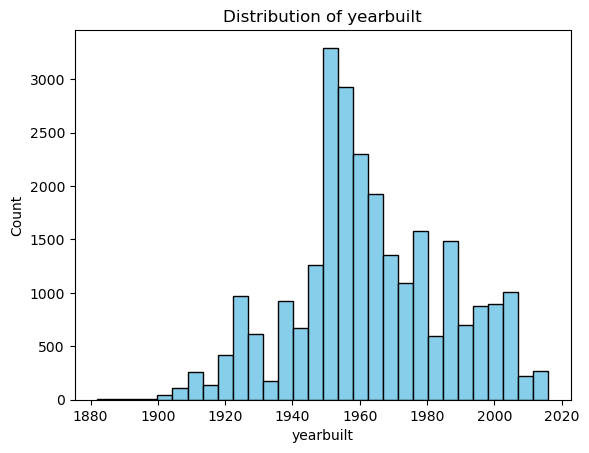

In [6]:
year_built = wrangle.plot_histogram(X_train, 'yearbuilt')

Is lot size important, I want to visualize the distribution.

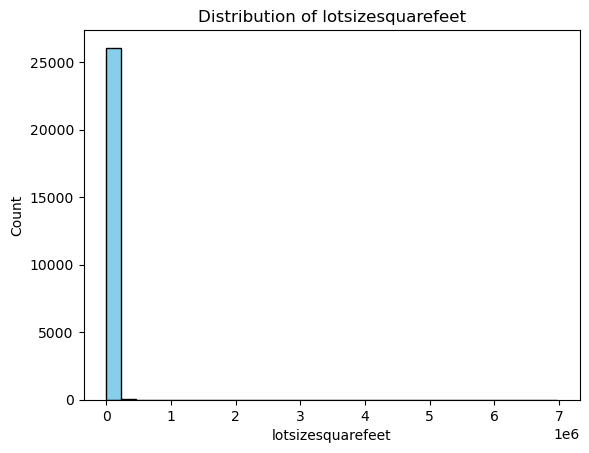

In [7]:
lot_size = wrangle.plot_histogram(X_train,'lotsizesquarefeet')

Do year built and fips (county) have any correlation?

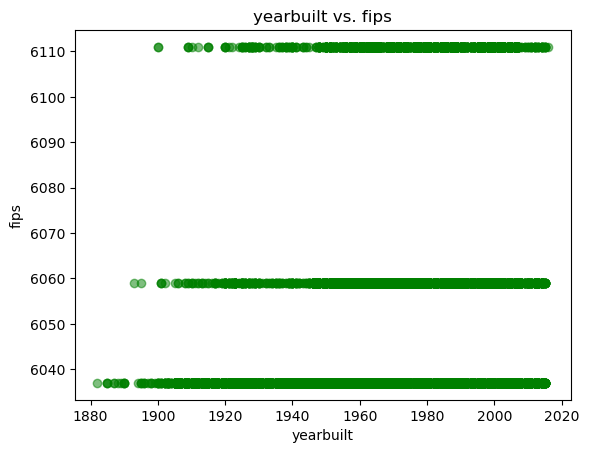

In [8]:
year_county = wrangle.plot_scatter(X_train, 'yearbuilt', 'fips')

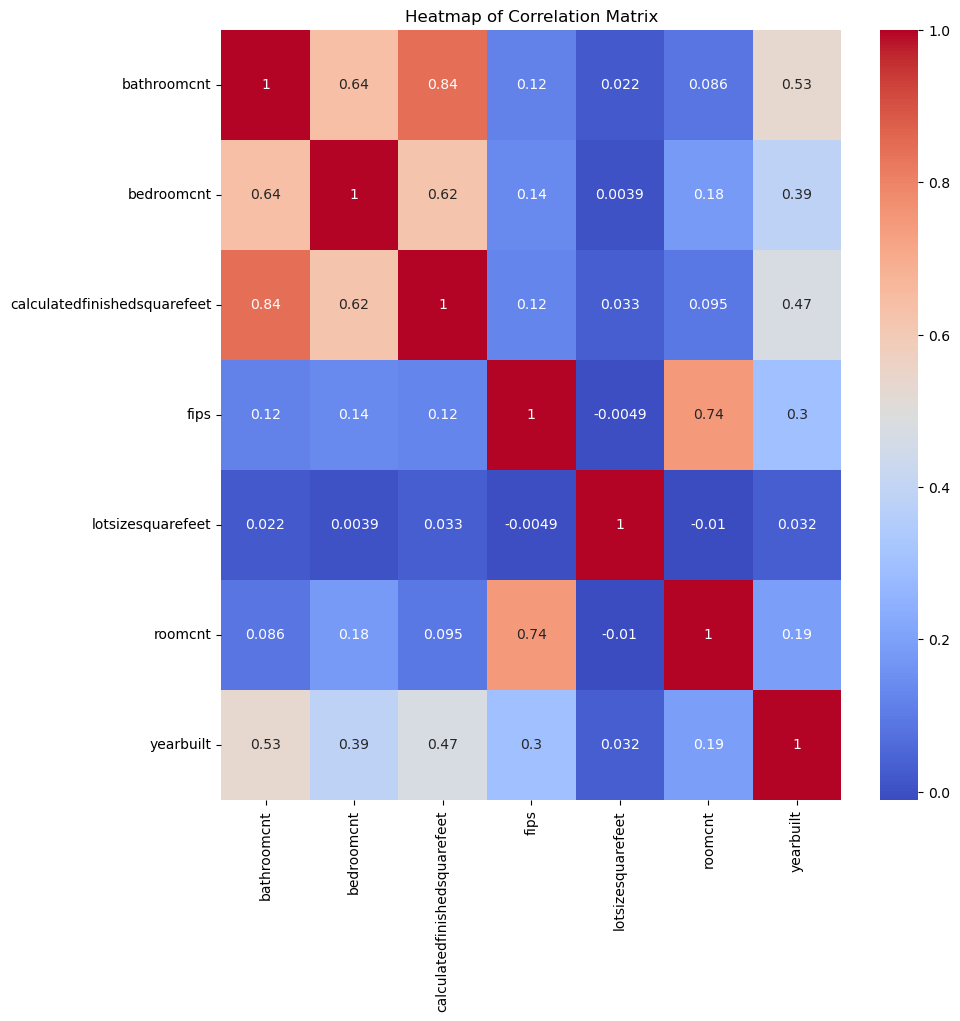

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), cmap='coolwarm', annot=True, ax=ax)
plt.title('Heatmap of Correlation Matrix')
plt.show()

Let's run a stats test to see if we can reject the null hypothois or not.


null_hypothesis = "There is no significant difference in the mean finished square feet between different counties.

alt_hypthesis = "There is a significant difference in the mean finished square feet between different counties.

Run a T-Test.

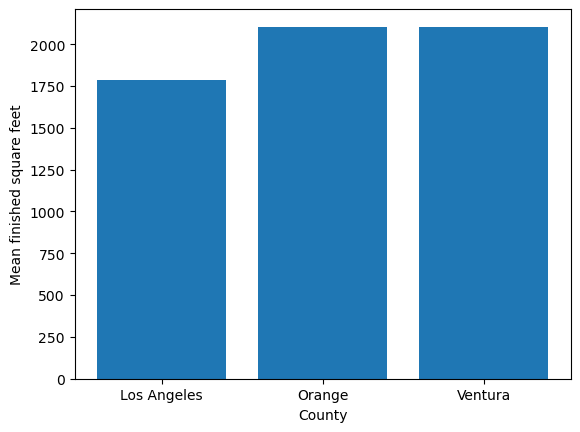

F-statistic: 336.87
p-value: 0.00
Reject null hypothesis. There is a significant difference in the mean finished square feet between different counties.


In [10]:
county_sqft = wrangle.county_sqft_test(X_train)

I noticed on the correlation heatmap that calculatedfinishedsquarefeet and yearbuilt also have a strong corrlation.
I want to run a stats test and get a visualization of this data.

My null hypothisis is that: "calculatedfinishedsquarefeet and yearbuilt have no correlation."

My alter hypothisis is that : "calculatedfinishedsquarefeet and yearbuilt have significant correlation."

Pearson correlation coefficient: 0.47
p-value: 0.00
Reject null hypothesis. calculatedfinishedsquarefeet and yearbuilt have significant correlation.


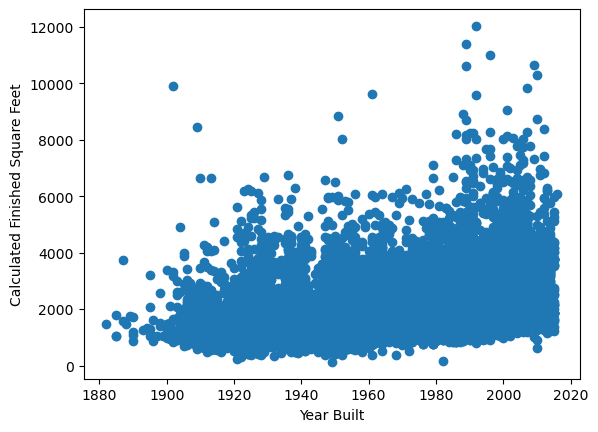

In [11]:
sqft_year_test = wrangle.sqft_year_test(X_train)

# Explore Summary
I think these stats tests help confirm a few of my questions...

Yes, yearbuilt and cal finished sq ft have some correlation.

So, I think anything that has a significant correlation with cal fin sq ft will be a decent predictor of 
property value in the end. 

I will be using yearbuilt, fips, and calculatedfinishedsquarefeet as my features for modeling.

# Feature Engineering
What are our top features?

In [12]:
top_features = wrangle.select_top_k_features(X_train, y_train, k=5)

In [13]:
top_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'yearbuilt']

We can see that calculatedfinsihedsquarefeet, fips, and yearbuilt are a few of our top features.
I will use them in the modeling stage.

### Below are the features I sent into the models!

In [14]:
# selecting desired columns
cols = ['fips', 'yearbuilt', 'calculatedfinishedsquarefeet']
# selecting columns for X_train
X_train = X_train[cols]
# selecting columns for X_validate
X_validate = X_validate[cols]
# selecting columns for X_test
X_test = X_test[cols]

# BaseLine

In [15]:
y_train.mean()

496908.0536794548

### These are our baseline numbers to beat... so the lower we are from these numbers the better!

In [16]:
baseline = wrangle.evaluate_model(y_train, y_validate)

RMSE using Mean
Train/In-Sample:  509364.66 
Validate/Out-of-Sample:  519236.24
RMSE using Median
Train/In-Sample:  524939.58 
Validate/Out-of-Sample:  535943.03


# MODELING

In [17]:
#PREP DATA FOR MODELING
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

### Linear Regression Prediction 

In [18]:
lr = wrangle.linear_regression(X_train, y_train, X_validate, y_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  396072.15702157293 
Validation/Out-of-Sample:  404534.6655727298


### Lasso + Lars

In [19]:
ll = wrangle.lasso_lars(X_train, y_train, X_validate, y_validate)

RMSE for Lasso + Lars
Training/In-Sample:  396072.2981397697 
Validation/Out-of-Sample:  404535.89006268425


### GLM Tweedie

In [20]:
# POWER AND ALPHA SET TO 0
glm_tweedie = wrangle.glm_tweedie(X_train, y_train, X_validate, y_validate)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  396313.6329554109 
Validation/Out-of-Sample:  404676.9418713971


### Polynomial Regression

In [21]:
# DEGREE'S SET TO 1
poly = wrangle.polynomial_regression(X_train, y_train, X_validate, y_validate, degree=1)

RMSE for Polynomial Regression, degrees=1
Training/In-Sample: 396072.16,           
Testing/Out-of-Sample: 404534.67


# Poly on the test dataset

I chose to do the polynomial regression on the test dataset because I liked the train and validate numbers slighly more and it allowed me to change the parameters (degrees) to 1.

In [22]:
test_poly = wrangle.polynomial_regression(X_train, y_train, X_test, y_test, degree=1)

RMSE for Polynomial Regression, degrees=1
Training/In-Sample: 396072.16,           
Testing/Out-of-Sample: 403371.08


# Summary and Recommendations

You can see that using fips(county), yearbuilt, and calculatedfinishedsquarefeet created a model slightly better than baseline, but not by much.

We may be able to use this model to predict property value slightly but I wouldn't use it if it's purpose is to make revenue in anyway.

I would recommend trying to locate the house more accuratly/precise than using fips because even within counties you have very high cost areas, vs very low cost areas from block to block. 

There are also many other attributes that contribute to property value, like flood/fire areas, or even what view the property may or may not have.

I think in the future this can be tailored in a MLM from block to block somehow to give a better prediction of property value. 